# Implement your own category

Using DisCoPy as a starting point, you can define whatever category is needed for your own project.
In Python, the definition of your custom category requires the following data:

* A subclass of `discopy.cat.Ob` for the objects in your category.
* A subclass of `discopy.cat.Arrow` for the arrows in your category, with attributes `dom` and `cod` for domain and codomain and methods `id` and `then` for identity and composition.

That's it! However with so little data, you can't do much with your category yet: you can only define functors from the free category into it, i.e. evaluate arbitrary compositions of arrows. In order to make use of DisCoPy's features, you will need a bit more structure: at least a [premonoidal category](https://ncatlab.org/nlab/show/premonoidal+category). Concretely, this means you need the following data:

* A subclass of `discopy.monoidal.Ty` for the objects in your category, with a method `tensor`. 
* A subclass of `discopy.monoidal.Diagram` or `discopy.monoidal.Box` for the arrows in your category, with attributes `dom` and `cod` for domain and codomain and methods `id`, `then` and `tensor` for identity, composition and tensor.

DisCoPy distinguishes two kinds of categories: _syntax categories_ and _semantic categories_. How do you know of which kind your category is? The rule of thumb is: if you can draw its arrows as diagrams, it's syntax, otherwise it must be semantics. Syntax categories should subclass `Diagram` while semantic categories subclass `Box`. In most applications you will need both syntax and semantic categories, together with a monoidal functor from syntax to semantics.

In this notebook, we will take a simple example of [abstract nonsense](https://en.wikipedia.org/wiki/Abstract_nonsense) --- the [Lawvere theory of sets](https://ncatlab.org/nlab/show/Lawvere+theory#TheoryOfSets) --- and make it concrete by implementing it in DisCoPy.

## Syntax categories

In DisCoPy, a syntax category is one where the arrows are subclass of `monoidal.Diagram`.

### Lawvere diagrams

A Lawvere theory is a [Cartesian monoidal category](https://ncatlab.org/nlab/show/cartesian+monoidal+category) generated by a single object `x`.
The tensor product being Cartesian is equivalent to `x` being equipped with a [natural](https://ncatlab.org/nlab/show/natural+transformation) [cocommutative comonoid](https://ncatlab.org/nlab/show/cocommutative+comonoid), this is something we can implement in terms of `Copy`, `Delete` and `Swap` boxes.

cocommutativity


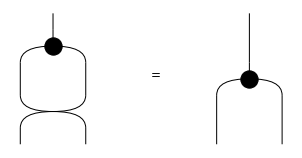

coassociativity


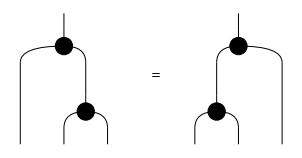

counitality


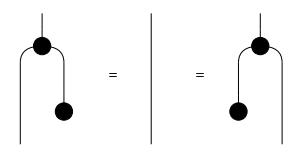

copy naturality


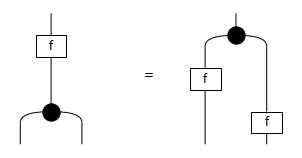

delete naturality


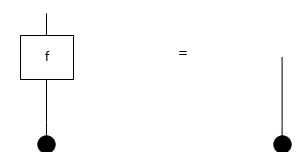

In [1]:
from discopy import monoidal, drawing

x = monoidal.Ty('x')

@factory
class Lawvere(monoidal.Diagram):
    """ A diagram in a Lawvere theory. """
    def __init__(self, dom, cod, boxes, offsets, layers=None):
        """ We check that the domain and codomain are generated by `x`. """
        assert all(obj.name == 'x' for obj in dom @ cod)
        super().__init__(dom, cod, boxes, offsets, layers)

    def __repr__(self):
        return super().__repr__().replace("Diagram", "Lawvere")
    
    def draw(self, **params):
        """ No need to draw the labels for types, they're all xs. """
        return super().draw(**dict(params, draw_type_labels=False))

class Id(monoidal.Id, Lawvere):
    """ Identity diagram in a Lawvere theory. """

Lawvere.id = Id  # We need to attach Id to the Diagram class

class Box(monoidal.Box, Lawvere):
    """ Box in a Lawvere theory. """

class Structure(Box, Lawvere):
    """ Structural morphism in a Lawvere theory, drawn as black spiders. """
    draw_as_spider, drawing_name, color = True, "", "black"

class Copy(Structure):
    """ The diagonal map from `x` to `x ** 2`."""
    def __init__(self):
        super().__init__(name="COPY", dom=x, cod=x ** 2)
    
class Delete(Structure):
    """ The unique map from `x` to the unit `x ** 0`."""
    def __init__(self):
        super().__init__(name="DEL", dom=x, cod=x ** 0)

class Swap(monoidal.Swap, Lawvere):
    """ The symmetry from `x @ x` to itself. """

COPY, DEL, SWAP = Copy(), Delete(), Swap(x, x)

f = Box('f', x, x)

axioms = {
    "cocommutativity": (COPY >> SWAP, COPY),
    "coassociativity": (COPY >> Id(x) @ COPY, COPY >> COPY @ Id(x)),
    "counitality": (COPY >> Id(x) @ DEL, Id(x), COPY >> DEL @ Id(x)),
    "copy naturality": (f >> COPY, COPY >> f @ f),
    "delete naturality": (f >> DEL, DEL)
}

for name, axiom in axioms.items():
    print(name)
    drawing.equation(*axiom, figsize=(4, 2))

### Structural morphisms

For now, we only have structure for the generating object `x`. In order to complete the definition, we need the same structure for `x ** n` for each `n >= 0` in a coherent way. Concretely, we need to attach static methods `copy`, `delete` and `swap` to the `Lawvere` class. The one for symmetry is already implemented by `monoidal.Diagram.swap`, we show the definition for copy and delete.

cocommutativity for x @ x


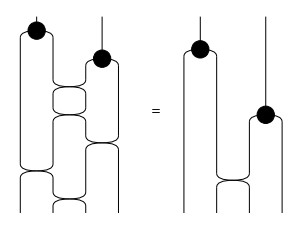

coassociativity for x @ x


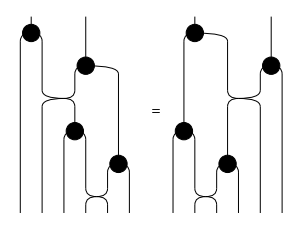

counitality for x @ x


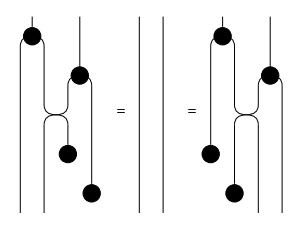

copy naturality for x @ x


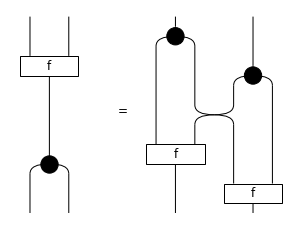

delete naturality for x @ x


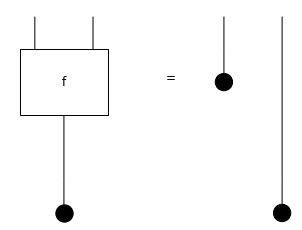

In [2]:
def swap(left, right):
    return monoidal.Diagram.swap(left, right, ar_factory=Lawvere, swap_factory=Swap)

def copy(xs):
    if not xs:  # xs is the unit `Ty()`
        return Id(xs)
    if len(xs) == 1:
        return COPY
    left, right = xs[:1], xs[:1]
    return copy(left) @ copy(right)\
        >> Id(left) @ swap(left, right) @ Id(right)

def delete(xs):
    if not xs:
        return Id(xs)
    if len(xs) == 1:
        return DEL
    left, right = xs[:1], xs[:1]
    return delete(left) @ delete(right)

Lawvere.swap, Lawvere.copy, Lawvere.delete = swap, copy, delete

copy_naturality = lambda f: (f >> copy(f.cod), copy(f.dom) >> f @ f)
delete_naturality = lambda f: (f >> delete(f.cod), delete(f.dom))

more_axioms = lambda xs: {    
    "cocommutativity": (copy(xs) >> swap(xs, xs), copy(xs)),
    "coassociativity": (copy(xs) >> Id(xs) @ copy(xs), copy(xs) >> copy(xs) @ Id(xs)),
    "counitality": (copy(xs) >> Id(xs) @ delete(xs), Id(xs), copy(xs) >> delete(xs) @ Id(xs)),
    "copy naturality": copy_naturality(Box('f', xs, x)),
    "delete naturality": delete_naturality(Box('f', xs, x))
}

xs = x ** 2
for name, axiom in more_axioms(xs).items():
    print("{} for {}".format(name, xs))
    drawing.equation(*axiom, figsize=(4, 3))

### Structure-preserving functors

Now that we have structural morphisms for all objects, we can define structure-preserving functors by subclassing `monoidal.Functor`.

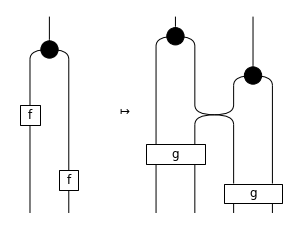

In [3]:
class CartesianFunctor(monoidal.Functor):
    def __init__(self, ob, ar, ob_factory=monoidal.Ty, ar_factory=Lawvere):
        super().__init__(ob, ar, ob_factory, ar_factory)

    def __call__(self, diagram):
        if isinstance(diagram, Copy):
            return self.ar_factory.copy(self(diagram.dom))
        if isinstance(diagram, Delete):
            return self.ar_factory.delete(self(diagram.dom))
        return super().__call__(diagram)

f, g = Box('f', x, x), Box('g', x ** 2, x ** 2)
diagram = copy_naturality(f)[1]

F = CartesianFunctor(ob={x: x ** 2}, ar={f: g})

drawing.equation(diagram, F(diagram), symbol="$\\mapsto$", figsize=(4, 3))

### Equality of diagrams

By default, the equality between DisCoPy diagrams is that of premonoidal categories: two diagrams are equal if and only if they are drawn exactly the same way.
Therefore, the axioms we have drawn for Lawvere theories are not implemented yet:

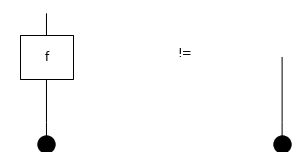

In [4]:
assert f >> DEL != DEL
drawing.equation(f >> DEL, DEL, symbol="!=", figsize=(4, 2))

In the abstract, we would like to implement a quotient of the free premonoidal category, where some diagrams get equated. In practice, these extra axioms can be implemented by redefining the equality method so that it first computes a _normal form_. For example, the interchanger axiom:

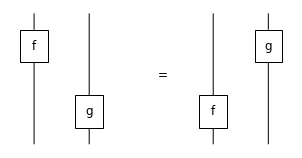

In [5]:
g = Box('g', x, x)
lhs = f @ Id(x) >> Id(x) @ g
rhs = Id(x) @ g >> f @ Id(x)
drawing.equation(lhs, rhs, figsize=(4, 2))

is implemented by the `monoidal.Diagram.normalize` generator. When we let `gen = d.normalize()`, calling `next(gen)` will output the next step in the rewriting process:

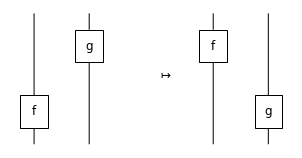

In [6]:
gen = rhs.normalize()
drawing.equation(rhs, next(gen), symbol="$\\mapsto$", figsize=(4, 2))

The method `monoidal.Diagram.normal_form` will return the last step of the process, if it ever terminates. Thus we can check for equality of monoidal diagrams with `lhs.normal_form() == rhs.normal_form()`:

In [7]:
assert lhs.normal_form() == rhs.normal_form()

**Exercice:** Implement the Lawvere theory of groups by adding generators for multiplication and inverse.

**Exercice:** Tweak the definition of `Lawvere` diagrams so that you can have multiple generating objects, i.e. implement colored Lawvere theories. Use that to implement the Lawvere theory of modules.

**Exercice (hard):** Take the rules from Lafont's [Algebraic Theory of Boolean Circuits (2003)](http://iml.univ-mrs.fr/~lafont/pub/circuits.pdf) and implement equality for diagrams in Lawvere theories.

In practice, computing normal forms for diagrams can become unfeasible: think of diagrams for quantum circuits, computing the normal form would amount to simulating the circuit.
In most applications, what we care about isn't whether diagrams are equal syntactically, but whether their evaluations are equal in a semantic category.

For the case of our `Lawvere` diagrams, there is a semantic category of choice: $\text{FinSet}^\text{op}$, the opposite of the category of finite sets and functions. This is what we implement in the next section.

## Semantic categories

In DisCoPy, a semantic category is one where the arrows are subclass of `monoidal.Box`.
In that case, `then` and `tensor` will return the result of some computation, rather than a diagram representing it.
We can then evaluate the diagrams in our syntax category by applying a functor into the semantic category.

### Finite sets as types

The objects of our category $\text{FinSet}^\text{op}$ are natural numbers with addition as tensor.
In order to make the most of DisCoPy's feature, we can represent a natural number `n` as a type with `objects=n * [1]`.

In [8]:
class FinSet(monoidal.Ty):
    """ A finite set is uniquely defined by its number of elements. """
    def __init__(self, n=0):
        super().__init__(*(n * [1]))
    
    def __repr__(self):
        return "FinSet({})".format(len(self))
    
    def tensor(self, *others):
        """ We take addition as tensor. """
        return FinSet(sum(len(t) for t in (self, ) + others))

### Functions as boxes

The arrows $m \to n$ in $\text{FinSet}^\text{op}$ are functions $\{0, \dots, n - 1\} \to \{0, \dots, m - 1\}$, with disjoint union as tensor.
We can encode those as Python dictionaries from `range(n)` to `range(m)`.
Thus, we can implement the arrows of our category as a subclass of `monoidal.Box`, with this mapping as `data` attribute.
We define `id`, `then` and `tensor`, as well as the structural morphisms `swap`, `copy` and `delete`.

In [9]:
class Map(monoidal.Box):
    """ The opposite of a function is defined by a dict from range(cod) to range(dom). """
    def __init__(self, dom, cod, data):
        name = "Function({}, {}, {})".format(dom, cod, data)
        assert set(data.keys()) == set(range(cod))
        assert all(i < dom for i in data.values())
        super().__init__(name, FinSet(dom), FinSet(cod), data=data)
    
    @staticmethod
    def id(dom):
        return Map(len(dom), len(dom), {i: i for i in range(len(dom))})
    
    def then(self, *others):
        if len(others) != 1:
            return super().then(*others)
        other, = others
        data = {i: self.data[j] for i, j in other.data.items()}
        return Map(len(self.dom), len(other.cod), data)
    
    def tensor(self, *others):
        if len(others) != 1:
            return super().tensor(*others)
        other, = others
        dom, cod = len(self.dom @ other.dom), len(self.cod @ other.cod)
        data = {
            i: self.data[i]
            if i < len(self.cod)
            else other.data[i - len(self.cod)]
            for i in range(cod)}
        return Map(dom, cod, data)
    
    @staticmethod
    def swap(left, right):
        data = {
            i: i + len(left) if i < len(left) else i - len(left)
            for i in range(len(left @ right))}
        return Map(len(left @ right), len(left @ right), data)
    
    @staticmethod
    def copy(dom):
        data = {i: i for i in range(len(dom))}
        data.update({i + len(dom): i for i in range(len(dom))})
        return Map(len(dom), len(dom ** 2), data)

    @staticmethod
    def delete(dom):
        return Map(len(dom), 0, {})

Equality now works on the nose!

In [10]:
X = FinSet(2)
m = Map.copy(X) >> Map.id(X) @ Map.delete(X)
assert m == Map.id(X)

However, drawing a `Map` will only print it in a box.

Function(2, 2, {0: 0, 1: 1})


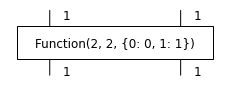

In [11]:
print(m)
m.draw(figsize=(3, 1))

### Algebras as functors

Now that we have our concrete category $\text{FinSet}^\text{op}$ implemented, we can define a structure-preserving functor from `Lawvere` diagrams into it, sending the generating object `x` to `FinSet(1)`.
In this particular example, this is enough to define equality of diagrams (assuming there are no boxes other than copy, delete and swap).
We can now check the axioms for cocommutative comonoids by evaluating their diagrams in $\text{FinSet}^\text{op}$.

In [12]:
F = CartesianFunctor(
    ob={x: FinSet(1)},
    ar={f: Map(1, 1, {0: 0}), g: Map(2, 2, {0: 1, 1: 0})},
    ob_factory=FinSet, ar_factory=Map)

def true_equal(self, other):
    return F(self) == F(other)

def all_equal(xs):
    return all(true_equal(x, xs[0]) for x in xs[1:])

for name, axiom in axioms.items():
    print("{}: {}".format(name, all_equal(axiom)))

cocommutativity: True
coassociativity: True
counitality: True
copy naturality: True
delete naturality: True


**Exercice:** Our functor `F` is one side of an equivalence from the Lawvere theory of sets to $\text{FinSet}^\text{op}$, try to implement the other side!
That is, implement a functor which sends `FinSet(n)` to `x ** n` and `Map` boxes to `Lawvere` diagrams.

**Hint:** Try to draw the mapping that defines a `Map` as a graph, that's your `Lawvere` diagram!